# Урок 6

## Домашнее задание.
Проект по итогам курса
По итогу занятий 1, 2, 3 и 4 у вас должна получиться таблица с данными об одном гене. Используя полученную информацию, проанализируйте её, проведите описательную статистику, постройте графики и прочее.

Чтобы посмотреть пример работы, обратитесь к разделу 4 на kaggle.com. Полученные результаты предоставляются в формате .ipynb.

1. Оценить частоту мутаций в популяциях по выбранному гену.
2. Оценить частоту мутаций в разрезе связанных заболеваний.

## Задание выполнено командой M4 Team.
__Состав команды:__  
 - Мгер Парунакян
 - Михаил Демин
 - Марат Закиров
 - Марина Дружинина

In [1]:
!pip install biopython
from Bio import Entrez
Entrez.email = "A.N.Other@example.com"
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import xml.etree.ElementTree as ET
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/GB/19_6_files'

/content/drive/MyDrive/Colab Notebooks/GB/19_6_files


### Получаем список генов по наименованию болезни из базы NCBI

In [4]:
def get_genes_by_disease(disease, retmax):
  disease_name = disease #Вносим название болезни во внутреннюю переменную
  handle = Entrez.esearch(db="gene", term=disease_name, retmax = retmax) #'retmax' Ограничиваем количество генов для вывода
  record = Entrez.read(handle)
  gene_ids = record["IdList"]
  return gene_ids

In [6]:
#Запрашиваем ID хромосомы из NCBI через параметр 'gi_id'.
#Эта процедура применяется в общей процедуре сбора информации по генам(см. ячейку ниже)
def search_chromosome(gi_id):
    handle = Entrez.esummary(db="nucleotide", id=gi_id)
    record = Entrez.read(handle)
    handle.close()
    return record[0]['AccessionVersion']

In [7]:
# Поиск в базе по имени гена
def search_gene_name(gene_id):
  handle = Entrez.esummary(db="gene", id=gene_id)
  record = Entrez.read(handle)
  handle.close()
  return record['DocumentSummarySet']['DocumentSummary'][0]['Name']

In [8]:
#Получаем из NCBI информацию о генах из списка 'gene_id_list', в том числе ID хромосомы.
def get_gene_info(gene_id_list):
  gene_info = []
  for gene_id in gene_id_list:
    handle = Entrez.efetch(db="gene", id=gene_id, rettype = 'xml')
    gene_locus = ET.parse(handle).getroot().find("Entrezgene/Entrezgene_locus")
    region = gene_locus.find("Gene-commentary/Gene-commentary_seqs/Seq-loc/Seq-loc_int/Seq-interval")
    start = int(region.find("Seq-interval_from").text) + 1
    end = int(region.find("Seq-interval_to").text) + 1
    gi_id = region.find("Seq-interval_id/Seq-id/Seq-id_gi").text
    strand = region.find("Seq-interval_strand/Na-strand").get("value")
    # print(gene_id, start, end, gi_id, strand)
    gene_info.append({'gene_name':search_gene_name(gene_id), 'gene_id':gene_id, 'interval_from':start, 'interval_to':end, 'gi_id':gi_id, 'nucleotide':search_chromosome(gi_id), 'strand':strand})
  return gene_info

In [9]:
%%time
gene_id_list = get_genes_by_disease('Apert syndrome', 30)
gene_list = get_gene_info(gene_id_list)

CPU times: user 1.02 s, sys: 95.5 ms, total: 1.11 s
Wall time: 1min 28s


In [10]:
#Предоставляем список генов в виде таблицы
df = pd.DataFrame(gene_list)
df['accession'] = df['nucleotide'].apply(lambda x: x.split('.')[0])
df['version'] = df['nucleotide'].apply(lambda x: x.split('.')[1])

In [11]:
df.T

,0,1,2,3,4,5,6,7
gene_name,FGFR2,Tnfsf11,Fgfr2,Fgf10,Pin1,Lrp5,Lrp6,FGF10
gene_id,2263,21943,14183,14165,23988,16973,16974,2255
interval_from,121478330,78514886,129764181,118851235,20563335,3634825,134423439,44300247
interval_to,121598458,78545483,129868538,118929109,20575008,3736574,134543876,44389420
gi_id,568815588,1877089955,1877089962,1877089956,1877089960,1877089950,1877089963,568815593
nucleotide,NC_000010.11,NC_000080.7,NC_000073.7,NC_000079.7,NC_000075.7,NC_000085.7,NC_000072.7,NC_000005.10
strand,minus,minus,minus,plus,plus,minus,minus,minus
accession,NC_000010,NC_000080,NC_000073,NC_000079,NC_000075,NC_000085,NC_000072,NC_000005
version,11,7,7,7,7,7,7,10


In [12]:
#Получаем нуклеотидную последовательность гена. Параметры берем из 'gene_list'
def get_dna_sequence(gene_seq_keys_list):
  gene_seq_list = []
  for nucleotid in gene_seq_keys_list:
    nucleotid_id = nucleotid['nucleotide']
    start = nucleotid['interval_from']
    end = nucleotid['interval_to']
    handle = Entrez.efetch(db="nucleotide",
                        id=nucleotid_id, 
                        rettype = 'fasta',
                        retmode = 'text')
    #загружаем нуклеотидную последовательность хромосомы
    chromosome = SeqIO.read(handle, 'fasta')
    gene_seq = chromosome.seq[start:end]
    gene_seq_list.append({'Gene ID': nucleotid["gene_id"], 'gen_seq': gene_seq})
  return gene_seq_list

In [13]:
%%time
gene_seq_list = get_dna_sequence(gene_list)
pprint(gene_seq_list)

[{'Gene ID': '2263',
  'gen_seq': Seq('ATTAAAAAAATAAGTTGCGTGACATTTATTTTGTCTTGTTAACATTAATATCTG...GCC')},
 {'Gene ID': '21943',
  'gen_seq': Seq('AGGTTTTCGTACAAATTTATTTTTTGTACCAAAAAATTAACATTCAGAGACAAT...GGC')},
 {'Gene ID': '14183',
  'gen_seq': Seq('TAAAAAAATAAGCTGCGTGACATTTATTTTGTCTTGTTAACATTAATATCTGTA...ATC')},
 {'Gene ID': '14165',
  'gen_seq': Seq('GCTTTCCAAGGGACTTGGAGGTGGAGAGAAGGGCCCAACAAAACGCCAGCCGCC...AGT')},
 {'Gene ID': '23988',
  'gen_seq': Seq('CCAATTGGCGTTTCTATTGGACGAGCCAATCACCAGCGGCGCTGCTCTGGCGCG...TTA')},
 {'Gene ID': '16973',
  'gen_seq': Seq('GGTATGTTTTAAAAAATTAAGTTTATAAATATTTTCTCCACTGTACAAAGTTTT...GAG')},
 {'Gene ID': '16974',
  'gen_seq': Seq('TTTCATTTTTTCCACTGATTTTTCCACTGTTTTATTATAAAAATCAACATTTCA...GCC')},
 {'Gene ID': '2255',
  'gen_seq': Seq('TTTTTTCTGTTTTTTTTTTATTTTACACTTAAACAATGAATGACATCAGGGTTT...GTC')}]
CPU times: user 10.4 s, sys: 3.11 s, total: 13.5 s
Wall time: 3min 34s


In [14]:
# Получаем информацию из базы данных SNP для гена FGFR2
gene_name = "FGFR2"
org = "homo sapiens"
# search ClinVar for variants in the gene
handle = Entrez.esearch(db="snp", term=f"{gene_name}[Gene Name]  AND {org}[Organism] AND (pathogenic[Clinical_Significance] OR likely pathogenic[Clinical_Significance] OR pathogenic likely pathogenic[Clinical_Significance])", retmax=100)
# handle = Entrez.esearch(db="snp", term=f"{gene_name}[Gene Name]  AND {org}[Organism]", retmax=60000)
record = Entrez.read(handle)
handle.close()
rs_list = record['IdList']
len(rs_list)

96

In [15]:
# Получаем информацию по каждой мутации из списка
def get_snp_rs_info(rs_list):
  snp_rs_info = []
  for k, i in enumerate(rs_list):
    print(f'\r{k} ' , end='')
    handle = Entrez.esearch(db="snp", term="rs" + i, format='gb')
    #handle = Entrez.efetch(db="snp", id="rs" + i)
    record = Entrez.read(handle)
    handle.close()
    idlist = record["IdList"]
    
    if len(idlist) > 0:
        handle = Entrez.esummary(db="snp", id=",".join(idlist))
        result = Entrez.read(handle)
        handle.close()
        snp_info = result['DocumentSummarySet']['DocumentSummary'][0]
        snp_rs_info.append({key: snp_info[key] for key in snp_info.keys()})
        # snp_rs_info.append({'SNP_ID':f"rs{snp_info['SNP_ID']}", 'GENES':snp_info['GENES'], 'ACC':snp_info['ACC'], 'SPDI':snp_info['SPDI'], 'ALLELE':" > ".join(snp_info['SPDI'].split(':')[2:]), 'CLINICAL_SIGNIFICANCE':snp_info['CLINICAL_SIGNIFICANCE'], 'CLINICAL_SORT':snp_info['CLINICAL_SORT']})
  return snp_rs_info

In [16]:
# search for the SNP record in NCBI dbSNP database
handle = Entrez.esearch(db="snp", term="rs77543610")
record = Entrez.read(handle)
print(record)
snp_rs_info=[]
# retrieve the relevant data for the SNP
handle = Entrez.esummary(db="snp", id=record["IdList"][0], rettype="asn.1")
record = Entrez.read(handle)
#snp_info = record['DocumentSummarySet']['DocumentSummary'][0]
#snp_rs_info.append({'SPDI':snp_info['SPDI']})
#snp_rs_info.append({'ALLELE':" > ".join(snp_info['SPDI'].split(':')[2:])})
pprint(record)

{'Count': '1', 'RetMax': '1', 'RetStart': '0', 'IdList': ['77543610'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'rs77543610[All Fields]', 'Field': 'All Fields', 'Count': '1', 'Explode': 'N'}, 'GROUP'], 'QueryTranslation': 'rs77543610[All Fields]'}
{'DocumentSummarySet': {'DbBuild': 'Build221118-1625.1',
                        'DocumentSummary': [{'ACC': 'NC_000010.11',
                                             'ALLELE': 'V',
                                             'ALLELE_ORIGIN': '',
                                             'CHR': '10',
                                             'CHRPOS': '10:121520160',
                                             'CHRPOS_PREV_ASSM': '10:123279674',
                                             'CHRPOS_SORT': '0121520160',
                                             'CITED_SORT': '',
                                             'CLINICAL_SIGNIFICANCE': 'likely-pathogenic,uncertain-significance,pathogenic',
                  

### 1. Оценить частоту мутаций в популяциях по выбранному гену

In [17]:
df = pd.read_parquet('M4team_dataset.parquet.gzip')

In [18]:
df_new = df.copy()

In [19]:
df_new.head(2)

,SNP_ID_RS,Study,Population,Group,Samplesize,Ref Allele,Alt Allele,SNP_ID,GLOBAL_MAFS,GLOBAL_SAMPLESIZE,...,SS,ALLELE,SNP_CLASS,CHRPOS,CHRPOS_PREV_ASSM,TEXT,SNP_ID_SORT,CLINICAL_SORT,CHRPOS_SORT,MERGED_SORT
0,rs2135483163,14KJPN,JAPANESE,Study-wide,28258,T=0.99996,C=0.00004,2135483163,"[{'STUDY': 'TOMMO', 'FREQ': 'C=0.00004/1'}]",0,...,5746300955,Y,snv,10:121593737,10:123353251,None,2135483163,0,121593737,0
1,rs2135479131,1000Genomes_30x,Global,Study-wide,6404,C=0.9998,G=0.0002,2135479131,"[{'STUDY': '1000Genomes', 'FREQ': 'G=0.0002/1'}]",0,...,5580559733,S,snv,10:121593509,10:123353023,None,2135479131,0,121593509,0


In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347687 entries, 0 to 347686
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   SNP_ID_RS              347687 non-null  object
 1   Study                  347687 non-null  object
 2   Population             347687 non-null  object
 3   Group                  347687 non-null  object
 4   Samplesize             347687 non-null  int64 
 5   Ref Allele             347687 non-null  object
 6   Alt Allele             347687 non-null  object
 7   SNP_ID                 347687 non-null  int64 
 8   GLOBAL_MAFS            347687 non-null  object
 9   GLOBAL_SAMPLESIZE      347687 non-null  int64 
 10  CLINICAL_SIGNIFICANCE  4260 non-null    object
 11  GENES                  347687 non-null  object
 12  ACC                    347687 non-null  object
 13  CHR                    347687 non-null  int64 
 14  HANDLE                 347687 non-null  object
 15  

In [21]:
sign_list = ['pathogenic',
       'pathogenic,likely-pathogenic,pathogenic-likely-pathogenic',
       'pathogenic,likely-pathogenic,uncertain-significance,benign-likely-benign',
       'likely-pathogenic,uncertain-significance,pathogenic',
       'likely-pathogenic', 
       'likely-pathogenic,pathogenic',
       'pathogenic,uncertain-significance']

In [22]:
df_new.columns

Index(['SNP_ID_RS', 'Study', 'Population', 'Group', 'Samplesize', 'Ref Allele',
       'Alt Allele', 'SNP_ID', 'GLOBAL_MAFS', 'GLOBAL_SAMPLESIZE',
       'CLINICAL_SIGNIFICANCE', 'GENES', 'ACC', 'CHR', 'HANDLE', 'SPDI',
       'FXN_CLASS', 'VALIDATED', 'DOCSUM', 'TAX_ID', 'ORIG_BUILD', 'UPD_BUILD',
       'CREATEDATE', 'UPDATEDATE', 'SS', 'ALLELE', 'SNP_CLASS', 'CHRPOS',
       'CHRPOS_PREV_ASSM', 'TEXT', 'SNP_ID_SORT', 'CLINICAL_SORT',
       'CHRPOS_SORT', 'MERGED_SORT'],
      dtype='object')

In [23]:
df_new.drop(columns=['SNP_ID',  'GLOBAL_SAMPLESIZE', 'CHR'], inplace=True)

In [24]:
df_new.CLINICAL_SIGNIFICANCE.value_counts()

likely-benign                                                               1214
uncertain-significance                                                      1120
benign                                                                       517
benign,likely-benign                                                         397
likely-benign,uncertain-significance                                         135
likely-benign,benign                                                         132
uncertain-significance,benign                                                104
pathogenic                                                                    71
benign,uncertain-significance,likely-benign                                   67
benign,likely-benign,benign-likely-benign                                     62
not-provided,likely-benign                                                    62
benign,benign-likely-benign,uncertain-significance                            56
benign-likely-benign,benign 

In [25]:
# rs_pat_list = df_fgfr2_pat.SNP_ID_RS.values.tolist()

In [26]:
df_new.Population.value_counts()

African                         42291
Other                           38671
European                        38240
Global                          35874
South Asian                     28416
Asian                           25984
Total                           24845
Latin American 2                24845
Latin American 1                24845
American                        17447
East Asian                      16343
Ashkenazi Jewish                13395
JAPANESE                         5914
Europe                           4042
KOREAN                           2359
PARENT AND CHILD COHORT           980
TWIN COHORT                       979
Estonian                          636
Genome of the Netherlands         344
ACPOP                             285
Danish                            161
European American                 123
African American                  123
Dominican                          32
SouthAsian                         32
NativeAmerican                     32
SouthAmerica

In [27]:
# Унификация названий популяции
d = {'America' : 'American', 'Europe' : 'European', 'Africa' : 'African',
     'AfricanAmerican': 'African American', 'Est_Asia': 'East Asian',
     'SouthAsian': 'South Asian'}
df_new['Population'] = df_new['Population'].apply(lambda x: d[x] if x in d.keys() else x)

# Удаление некоторых категорий 
df_new = df_new.loc[~df_new['Population'].isin(['PARENT AND CHILD COHORT', 'TWIN COHORT', 'ACPOP', 'Other', 'Total', 'Global', 'CRM'])]

In [28]:
# df_new = df_new[df['Ref Allele'] !='-\nNo frequency provided']
df_new['Alt_Allele'] = df_new['Alt Allele'].apply(lambda x: x.split('=')[0])
df_new['Alt_Allele_frequency'] = df_new['Alt Allele'].apply(lambda x: x.split('=')[1].split(',')[0]).astype(float)

In [29]:
# Удаление строк, где Samplesize = 0
df_new = df_new[df_new['Samplesize']!= 0]

In [30]:
df_new.loc[df_new['Samplesize']== 0]

,SNP_ID_RS,Study,Population,Group,Samplesize,Ref Allele,Alt Allele,GLOBAL_MAFS,CLINICAL_SIGNIFICANCE,GENES,...,SNP_CLASS,CHRPOS,CHRPOS_PREV_ASSM,TEXT,SNP_ID_SORT,CLINICAL_SORT,CHRPOS_SORT,MERGED_SORT,Alt_Allele,Alt_Allele_frequency


In [31]:
# Отфильтруем данные по CLINICAL_SIGNIFICANCE = pathogenic
df1_new = df_new.loc[df_new['CLINICAL_SIGNIFICANCE'].isin(['pathogenic'])]

In [32]:
df1_new.groupby(['Population', 'Alt_Allele']).agg({'Alt_Allele_frequency': ['max', 'mean', 'sum'], 'Samplesize': ['max', 'sum']}).reset_index()

Population Alt_Allele Alt_Allele_frequency                    \
                                                 max     mean      sum   
0            African          A              0.00000  0.00000  0.00000   
1            African          C              0.00000  0.00000  0.00000   
2            African          G              0.00000  0.00000  0.00000   
3            African          T              0.00000  0.00000  0.00000   
4           American          A              0.00000  0.00000  0.00000   
5           American          C              0.00003  0.00003  0.00003   
6   Ashkenazi Jewish          C              0.00000  0.00000  0.00000   
7              Asian          A              0.00000  0.00000  0.00000   
8              Asian          C              0.00000  0.00000  0.00000   
9              Asian          T              0.00000  0.00000  0.00000   
10          European          A              0.00001  0.00001  0.00001   
11          European          C              0.00000  0.00000  0.00000   
12          European          T              0.00000  0.00000  0.00000   
13  Latin American 1          C              0.00000  0.00000  0.00000   
14  Latin American 1          T              0.00000  0.00000  0.00000   
15  Latin American 2          C              0.00000  0.00000  0.00000   
16  Latin American 2          T              0.00000  0.00000  0.00000   
17       South Asian          C              0.00000  0.00000  0.00000   
18       South Asian          T              0.00000  0.00000  0.00000   

   Samplesize          
          max     sum  
0       10406   10832  
1       16256   19828  
2         426     850  
3        2294    2294  
4       11566   11566  
5       34592   34592  
6       10078   10078  
7       25124   25124  
8       49008   49116  
9         108     108  
10      73308   73308  
11     135280  142242  
12       6962    6962  
13        146     146  
14        146     146  
15        610     610  
16        610     610  
17         94      94  
18         94      94

In [33]:
df1_new.Population.value_counts()

African             9
European            4
Asian               4
Latin American 2    2
Latin American 1    2
South Asian         2
American            2
Ashkenazi Jewish    1
Name: Population, dtype: int64

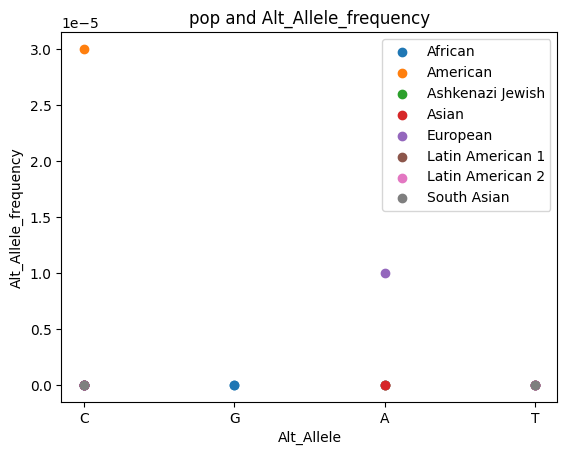

In [34]:
fig, ax = plt.subplots()
for title, group in df1_new.groupby('Population'):
    ax.scatter(group['Alt_Allele'], group['Alt_Allele_frequency'], label=title)

plt.xlabel('Alt_Allele')
plt.ylabel('Alt_Allele_frequency')
plt.title('pop and Alt_Allele_frequency')

plt.legend()
plt.show()

In [35]:
# Посмотрим частоту альтернативных аллелей в пределах одной популяции
df_american = df1_new.loc[df1_new['Population'].isin(['American']) & df1_new['Alt_Allele'].isin(['A', 'T', 'G', 'C'])]

In [36]:
df_american.groupby(['Population', 'Alt_Allele']).agg({'Alt_Allele_frequency': ['max', 'mean', 'sum'], 'Samplesize': ['max', 'sum']}).reset_index()

Population Alt_Allele Alt_Allele_frequency                   Samplesize  \
                                         max     mean      sum        max   
0   American          A              0.00000  0.00000  0.00000      11566   
1   American          C              0.00003  0.00003  0.00003      34592   

          
     sum  
0  11566  
1  34592

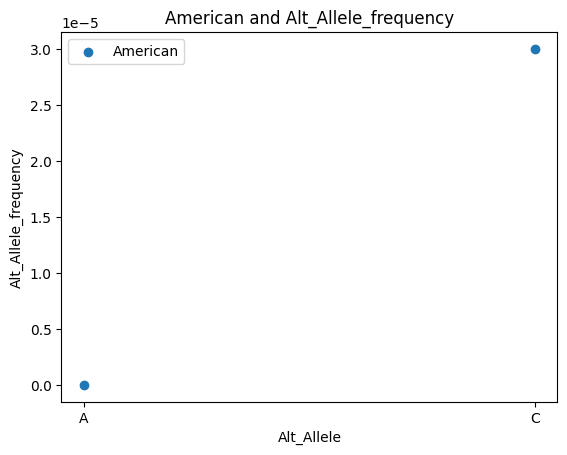

In [37]:
fig, ax = plt.subplots()

for title, group in df_american.groupby('Population'):
    ax.scatter(group['Alt_Allele'], group['Alt_Allele_frequency'], label=title)

plt.xlabel('Alt_Allele')
plt.ylabel('Alt_Allele_frequency')
plt.title('American and Alt_Allele_frequency')

plt.legend()
plt.show()

In [38]:
df_european = df1_new.loc[df1_new['Population'].isin(['European']) & df1_new['Alt_Allele'].isin(['A', 'T', 'G', 'C'])]

In [39]:
df_european.groupby(['Population', 'Alt_Allele']).agg({'Alt_Allele_frequency': ['max', 'mean', 'sum'], 'Samplesize': ['max', 'sum']}).reset_index()

Population Alt_Allele Alt_Allele_frequency                   Samplesize  \
                                         max     mean      sum        max   
0   European          A              0.00001  0.00001  0.00001      73308   
1   European          C              0.00000  0.00000  0.00000     135280   
2   European          T              0.00000  0.00000  0.00000       6962   

           
      sum  
0   73308  
1  142242  
2    6962

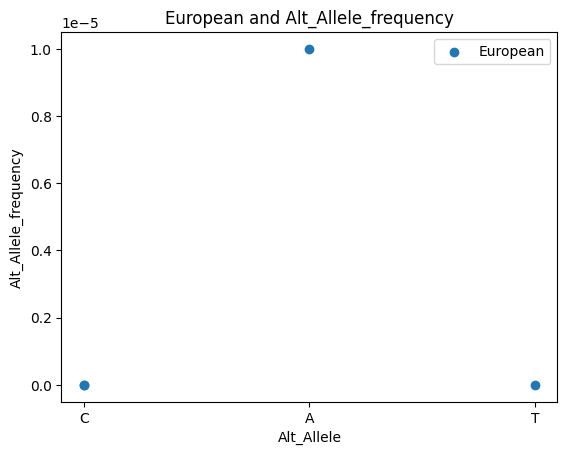

In [40]:
fig, ax = plt.subplots()

for title, group in df_european.groupby('Population'):
    ax.scatter(group['Alt_Allele'], group['Alt_Allele_frequency'], label=title)

plt.xlabel('Alt_Allele')
plt.ylabel('Alt_Allele_frequency')
plt.title('European and Alt_Allele_frequency')

plt.legend()
plt.show()

На основании полученных данных было выявлено, что в популяции American наибольшая частотность альтернативных аллелей в основании С, а у популяции European в основании А. 

### 2. Оценить частоту мутаций в разрезе связанных заболеваний.

In [41]:
df2 = pd.read_parquet('FGFR2_disease_dataset.parquet.gzip')

In [42]:
df_dis = df2.copy()
df_dis.head(2)

,index,SNP_ID_RS,ClinVar_Accession,Disease_Names,Clinical_Significance,Mutation_type,SNP_ID,ALLELE_ORIGIN,GLOBAL_MAFS,GLOBAL_POPULATION,...,ALLELE,SNP_CLASS,CHRPOS,CHRPOS_PREV_ASSM,TEXT,SNP_ID_SORT,CLINICAL_SORT,CITED_SORT,CHRPOS_SORT,MERGED_SORT
0,0,rs2134256765,RCV002224437.1,not provided,Likely-Pathogenic,Inframe Indel,2134256765,NaN,[],NaN,...,N,ins,10:121517381,10:123276896,NaN,2134256765,1,NaN,121517381,0
1,0,rs2134256250,RCV001390280.4,FGFR2 related craniosynostosis,Pathogenic,Missense Variant,2134256250,NaN,[],NaN,...,N,snv,10:121517373,10:123276887,NaN,2134256250,1,NaN,121517373,0


In [43]:
df_dis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  204 non-null    int64  
 1   SNP_ID_RS              204 non-null    object 
 2   ClinVar_Accession      204 non-null    object 
 3   Disease_Names          204 non-null    object 
 4   Clinical_Significance  204 non-null    object 
 5   Mutation_type          204 non-null    object 
 6   SNP_ID                 204 non-null    int64  
 7   ALLELE_ORIGIN          0 non-null      float64
 8   GLOBAL_MAFS            204 non-null    object 
 9   GLOBAL_POPULATION      0 non-null      float64
 10  GLOBAL_SAMPLESIZE      204 non-null    int64  
 11  SUSPECTED              0 non-null      float64
 12  CLINICAL_SIGNIFICANCE  204 non-null    object 
 13  GENES                  204 non-null    object 
 14  ACC                    204 non-null    object 
 15  CHR   

In [44]:
df_dis.drop(columns=['ALLELE_ORIGIN', 'GLOBAL_SAMPLESIZE', 'GLOBAL_POPULATION', 'CHR', 'SUSPECTED', 'TEXT', 'CITED_SORT' ], inplace=True)

In [45]:
df_dis.columns

Index(['index', 'SNP_ID_RS', 'ClinVar_Accession', 'Disease_Names',
       'Clinical_Significance', 'Mutation_type', 'SNP_ID', 'GLOBAL_MAFS',
       'CLINICAL_SIGNIFICANCE', 'GENES', 'ACC', 'HANDLE', 'SPDI', 'FXN_CLASS',
       'VALIDATED', 'DOCSUM', 'TAX_ID', 'ORIG_BUILD', 'UPD_BUILD',
       'CREATEDATE', 'UPDATEDATE', 'SS', 'ALLELE', 'SNP_CLASS', 'CHRPOS',
       'CHRPOS_PREV_ASSM', 'SNP_ID_SORT', 'CLINICAL_SORT', 'CHRPOS_SORT',
       'MERGED_SORT'],
      dtype='object')

In [46]:
df_dis.Disease_Names.value_counts()

FGFR2 related craniosynostosis                                                                                                                                                                                                                                                                                                                                                                                                                                                                    40
not provided                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      36
Crouzon syndrome              

In [47]:
# Унификация названий болезней
d = {'Craniosynostosis, nonspecific' : 'FGFR2-related syndromic and non-syndromic craniosynostoses', 
     'Craniosynostosis syndrome' : 'FGFR2-related syndromic and non-syndromic craniosynostoses',
     'Craniosynostosis, nonsyndromic unicoronal' : 'FGFR2-related syndromic and non-syndromic craniosynostoses',
     'Craniosynostosis, nonclassifiable autosomal dominant': 'FGFR2-related syndromic and non-syndromic craniosynostoses',
     'FGFR2 related craniosynostosis': 'FGFR2-related syndromic and non-syndromic craniosynostoses',
     'Pfeiffer syndrome variant': 'Pfeiffer syndrome',
     'Pfeiffer syndrome type 3': 'Pfeiffer syndrome',
     'Squamous cell lung carcinoma': 'Lung adenocarcinoma',
     'Abnormal pinna morphology,Abnormal posterior cranial fossa morphology,Abnormal zygomatic bone morphology,Brachyturricephaly,Choanal stenosis,Cranial asymmetry,Deviated nasal septum,Dilation of lateral ventricles,Downslanted palpebral fissures,Facial asymmetry,Flat occiput,High forehead,High palate,Hydrocephalus,Hypertelorism,Hypointensity of cerebral white matter on MRI,Low-set ears,Mild fetal ventriculomegaly,Narrow forehead,Shallow orbits,Short neck,Wide anterior fontanel':
     'Craniofacial-skeletal-dermatologic dysplasia',
     'Acrocephalosyndactyly type I,Antley-Bixler syndrome without genital anomalies or disordered steroidogenesis,Beare-Stevenson cutis gyrata syndrome,Crouzon syndrome,FGFR2-related bent bone dysplasia,Familial scaphocephaly syndrome, McGillivray type,Jackson-Weiss syndrome,Levy-Hollister syndrome,Neoplasm of stomach,Pfeiffer syndrome,Saethre-Chotzen syndrome':
     'Undefined FGFR2-related syndrome',
     'Acrocephalosyndactyly type I': 'Apert syndrome',
     'not provided': '[Not provided]'}
df_dis['Disease_Names'] = df_dis['Disease_Names'].apply(lambda x: d[x] if x in d.keys() else x)

# Удаление некоторых категорий 
# df_dis = df_dis.loc[~df_dis['Disease_Names'].isin(['not provided'])]

In [48]:
df_dis.Disease_Names.value_counts()

FGFR2-related syndromic and non-syndromic craniosynostoses                        47
[Not provided]                                                                    36
Crouzon syndrome                                                                  24
Pfeiffer syndrome                                                                 18
Endometrial Endometrioid Adenocarcinoma, Variant with Squamous Differentiation     9
Endometrial neoplasm                                                               8
Apert syndrome                                                                     6
Levy-Hollister syndrome                                                            6
Undefined FGFR2-related syndrome                                                   5
Malignant neoplasm of body of uterus                                               5
Lung adenocarcinoma                                                                4
Inborn genetic diseases                                          

In [49]:
df_dis.SNP_CLASS.value_counts()

snv       188
delins      7
mnv         6
del         2
ins         1
Name: SNP_CLASS, dtype: int64

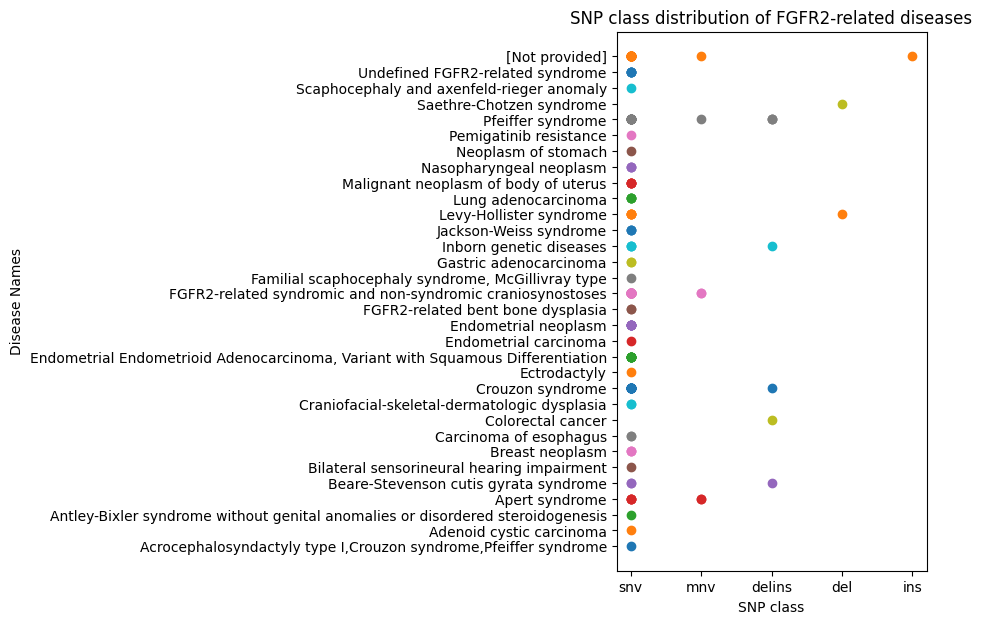

In [50]:
fig, ax = plt.subplots()

for title, group in df_dis.groupby('Disease_Names'):
    ax.scatter(group['SNP_CLASS'], group['Disease_Names'])

fig.set_figheight(7)
fig.set_figwidth(4)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.xlabel('SNP class')
plt.ylabel('Disease Names')
plt.title('SNP class distribution of FGFR2-related diseases')

# plt.legend()
plt.show()

In [51]:
df_dis['Mutation_type'].value_counts()

Missense Variant           162
Stop Gained                 12
Synonymous Variant           9
Splice Acceptor Variant      7
Intron Variant               5
Inframe Indel                3
Inframe Deletion             3
Splice Donor Variant         2
Inframe Insertion            1
Name: Mutation_type, dtype: int64

In [52]:
# Унификация названий типов мутаций
d = {'Missense Variant' : 'Missense', 
     'Stop Gained' : 'Nonsense (Stop Gained)',
     'Synonymous Variant' : 'Synonymous',
     'Splice Acceptor Variant' : 'Splice Acceptor',
     'Splice Donor Variant' : 'Splice Donor',
     'Intron Variant' : 'Intron'}
df_dis['Mutation_type'] = df_dis['Mutation_type'].apply(lambda x: d[x] if x in d.keys() else x)

In [53]:
df_dis['Mutation_type'].value_counts()

Missense                  162
Nonsense (Stop Gained)     12
Synonymous                  9
Splice Acceptor             7
Intron                      5
Inframe Indel               3
Inframe Deletion            3
Splice Donor                2
Inframe Insertion           1
Name: Mutation_type, dtype: int64

<ipython-input-56-9b53ef72ab52>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


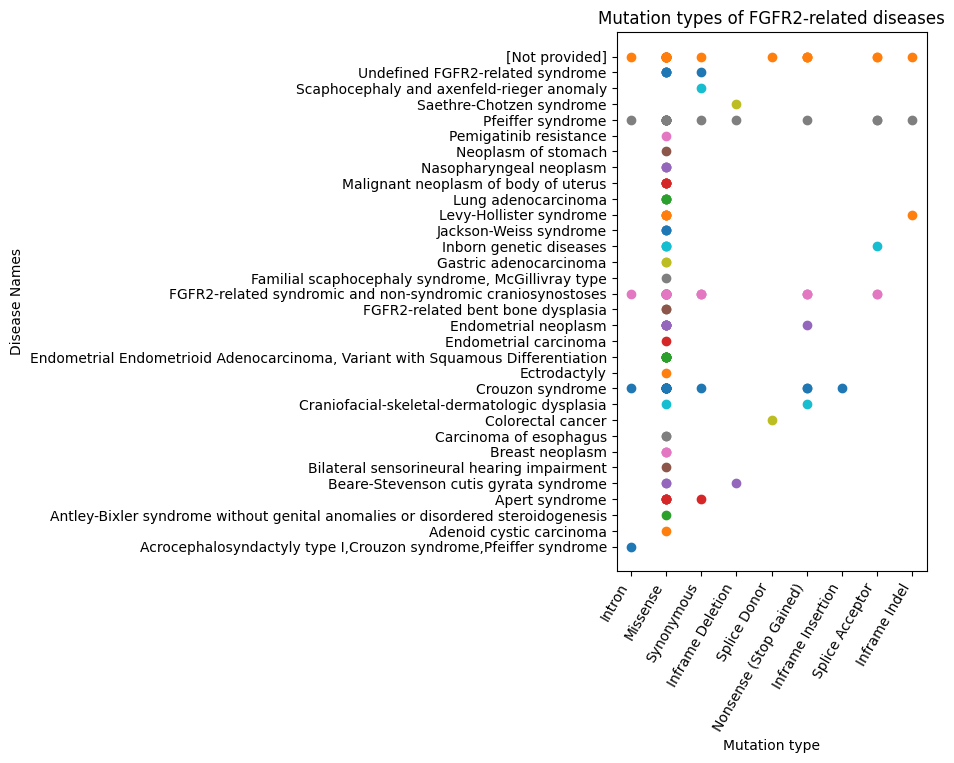

In [56]:
fig, ax = plt.subplots()

for title, group in df_dis.groupby('Disease_Names'):
    ax.scatter(group['Mutation_type'], group['Disease_Names'])

fig.set_figheight(7)
fig.set_figwidth(4)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

plt.xlabel('Mutation type')
plt.ylabel('Disease Names')
plt.title('Mutation types of FGFR2-related diseases')

# plt.legend()
plt.show()

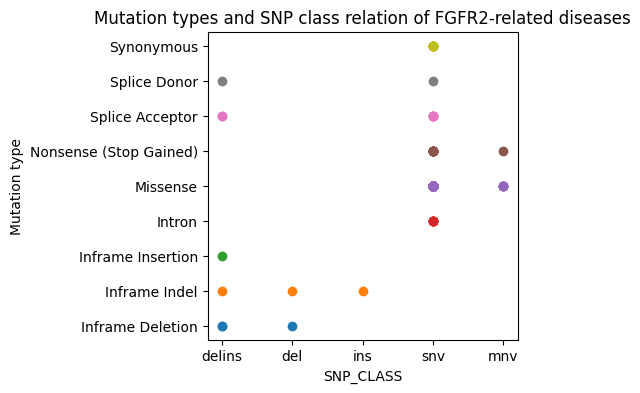

In [59]:
fig, ax = plt.subplots()

for title, group in df_dis.groupby('Mutation_type'):
    ax.scatter(group['SNP_CLASS'], group['Mutation_type'])

fig.set_figheight(4)
fig.set_figwidth(4)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

plt.xlabel('SNP_CLASS')
plt.ylabel('Mutation type')
plt.title('Mutation types and SNP class relation of FGFR2-related diseases')

# plt.legend()
plt.show()